# Long Short-Term Memory (LSTM) para Análisis de Series de Tiempo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
tf.random.set_seed(21562)

# Preparación de datos

Cargamos los datos

In [3]:
df = pd.read_csv('data/precios.csv', parse_dates=['Fecha'], index_col='Fecha')

In [4]:
df.head()

,Super,Regular,Diesel
Fecha,,,
2002-01-01,12.55,12.19,8.95
2002-02-01,12.29,11.90,8.66
2002-03-01,12.58,12.17,8.69
2002-04-01,14.11,13.71,9.38
2002-05-01,14.16,13.79,9.44


Visualización de los datos

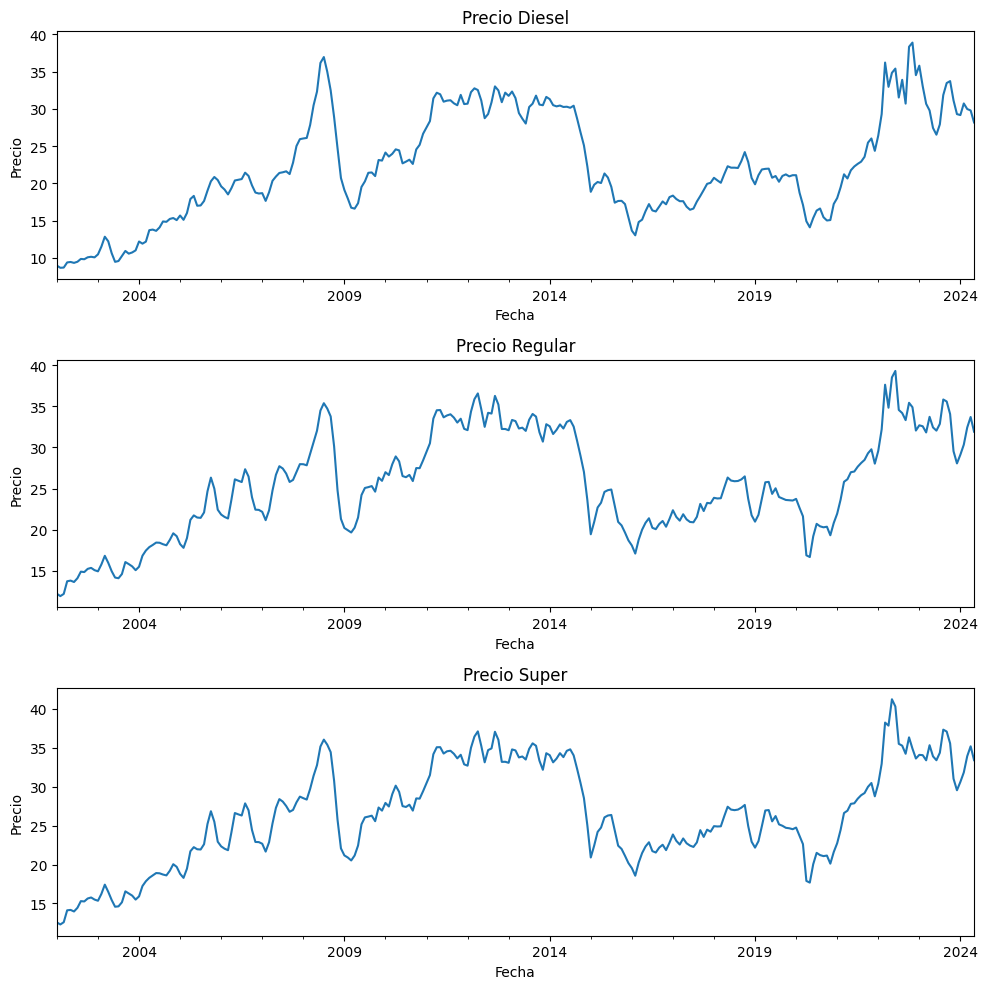

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

plt.show()

Descompocisión de la serie de tiempo

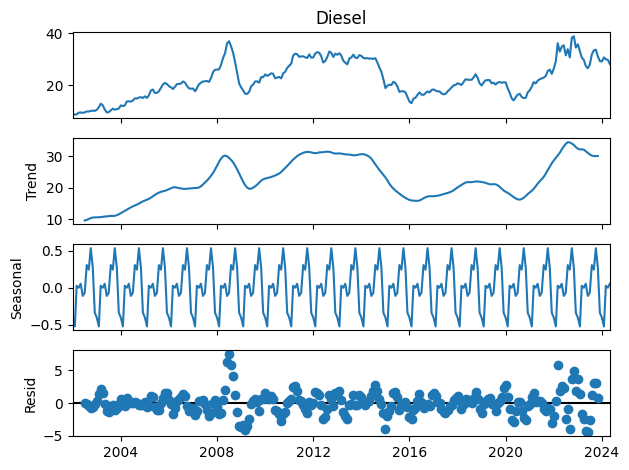

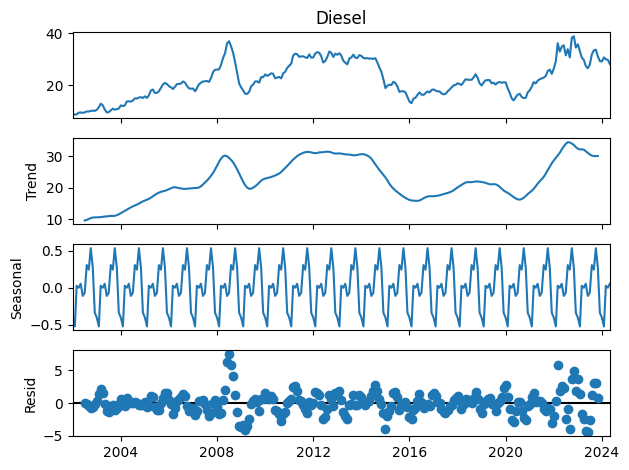

In [6]:
seasonal_decompose(df['Diesel'], model='additive', period=12).plot()

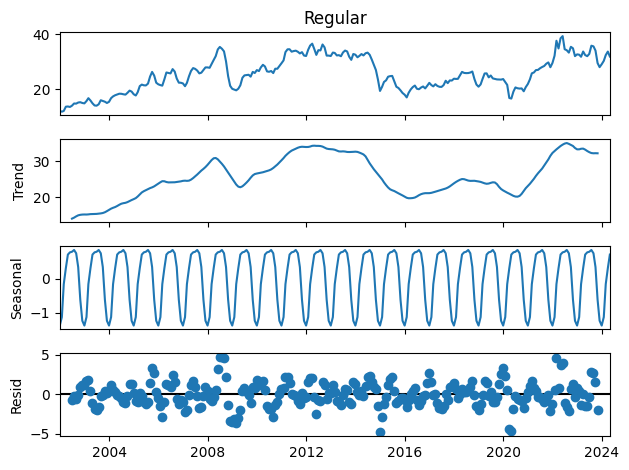

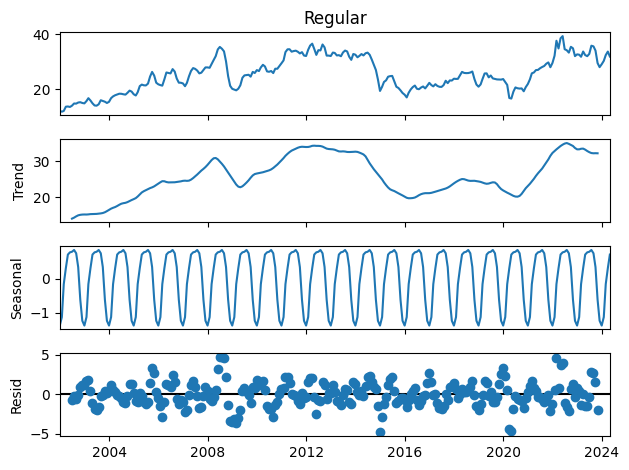

In [7]:
seasonal_decompose(df['Regular'], model='additive', period=12).plot()

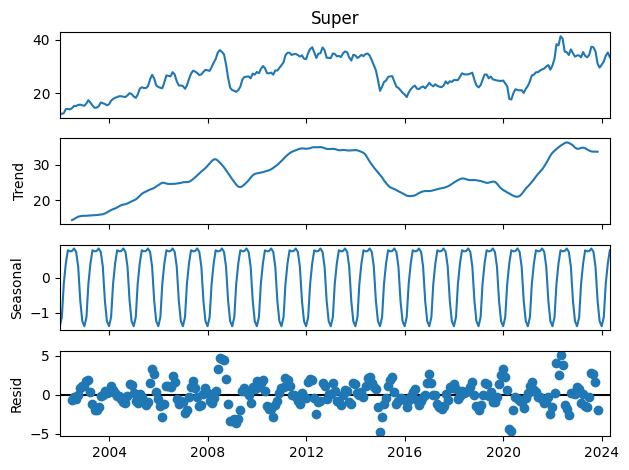

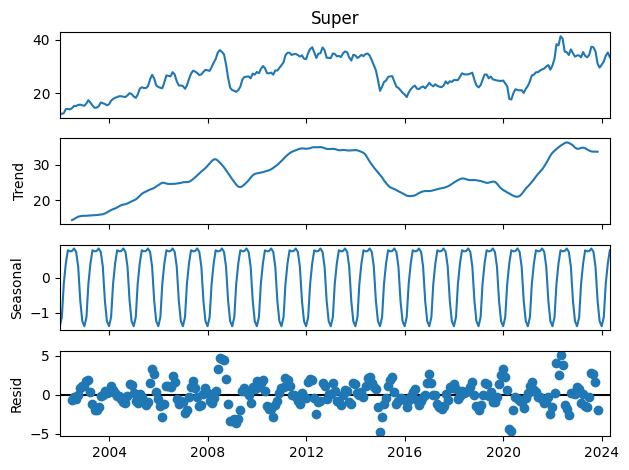

In [8]:
seasonal_decompose(df['Super'], model='additive', period=12).plot()

Diferenciación de la serie de tiempo

In [9]:
df['Diesel_diff'] = df['Diesel'].diff()

In [10]:
df['Regular_diff'] = df['Regular'].diff()

In [11]:
df['Super_diff'] = df['Super'].diff()

Eliminamos los valores nulos

In [12]:
df.dropna(inplace=True)

In [13]:
df.head()

,Super,Regular,Diesel,Diesel_diff,Regular_diff,Super_diff
Fecha,,,,,,
2002-02-01,12.29,11.90,8.66,-0.29,-0.29,-0.26
2002-03-01,12.58,12.17,8.69,0.03,0.27,0.29
2002-04-01,14.11,13.71,9.38,0.69,1.54,1.53
2002-05-01,14.16,13.79,9.44,0.06,0.08,0.05
2002-06-01,13.96,13.62,9.32,-0.12,-0.17,-0.20


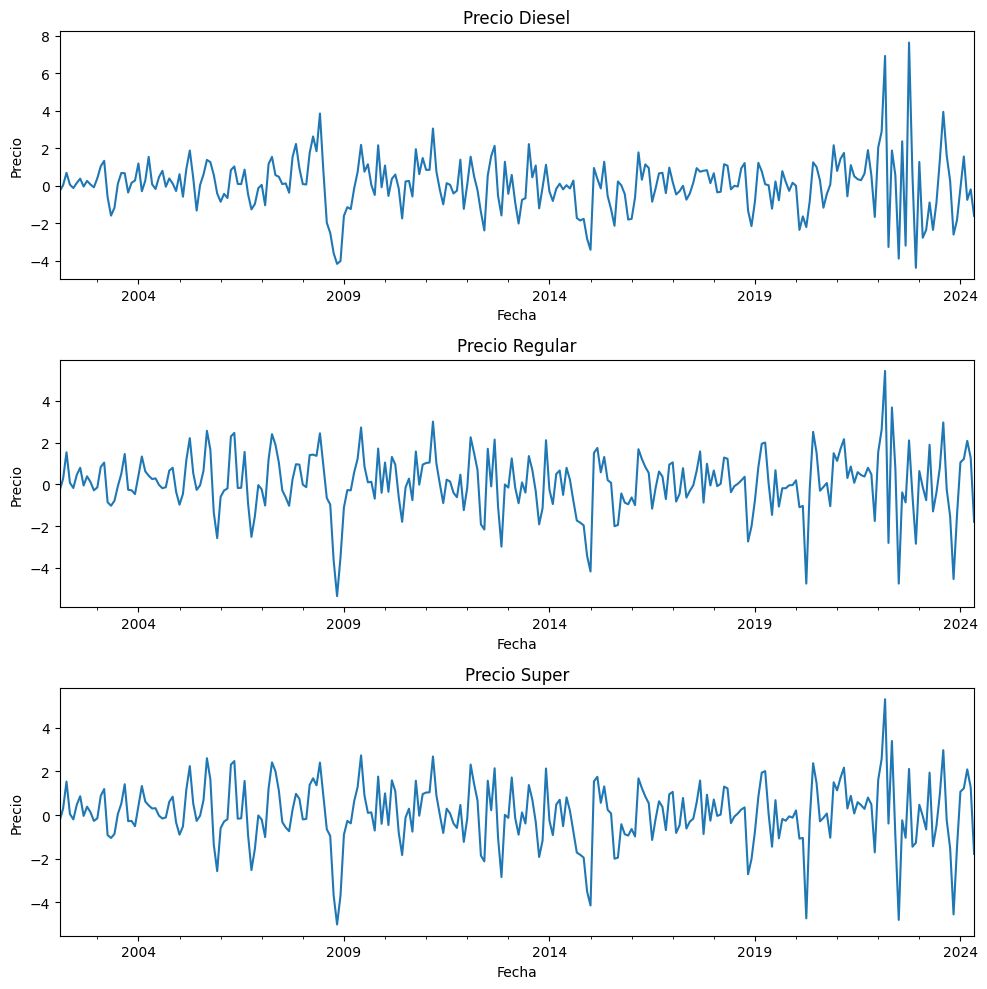

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel_diff'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular_diff'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super_diff'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

Normalización de los datos

In [15]:
scaler = MinMaxScaler(
    feature_range=(0, 1)
)

In [16]:
diesel_data = df['Diesel_diff'].values.reshape(-1, 1)
diesel_data = scaler.fit_transform(diesel_data)

In [17]:
regular_data = df['Regular_diff'].values.reshape(-1, 1)
regular_data = scaler.fit_transform(regular_data)

In [18]:
super_data = df['Super_diff'].values.reshape(-1, 1)
super_data = scaler.fit_transform(super_data)

Creación de secuencias

In [19]:
def create_sequences(data, seq_length=1, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Crea secuencias de datos "supervisados". Se crea una matriz bidimensional donde la dimennsión 0 es t-1 y la dimensión 1 es t.
    :param data: 
    :param seq_length: 
    :return: 
    """
    train_idx = int(len(data) * train_size)
    val_idx = int(len(data) * (train_size + val_size))

    train_data = data[:train_idx]
    val_data = data[train_idx:val_idx]
    test_data = data[val_idx:]

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for i in range(seq_length, len(train_data)):
        X_train.append(train_data[i - seq_length:i, 0])
        y_train.append(train_data[i, 0])

    for i in range(seq_length, len(val_data)):
        X_val.append(val_data[i - seq_length:i, 0])
        y_val.append(val_data[i, 0])

    for i in range(seq_length, len(test_data)):
        X_test.append(test_data[i - seq_length:i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [20]:
diesel_split = create_sequences(diesel_data)

X_train_diesel = diesel_split[0]
y_train_diesel = diesel_split[1]
X_val_diesel = diesel_split[2]
y_val_diesel = diesel_split[3]
X_test_diesel = diesel_split[4]
y_test_diesel = diesel_split[5]

In [21]:
regular_split = create_sequences(regular_data)

X_train_regular = regular_split[0]
y_train_regular = regular_split[1]
X_val_regular = regular_split[2]
y_val_regular = regular_split[3]
X_test_regular = regular_split[4]
y_test_regular = regular_split[5]

In [22]:
super_split = create_sequences(super_data)

X_train_super = super_split[0]
y_train_super = super_split[1]
X_val_super = super_split[2]
y_val_super = super_split[3]
X_test_super = super_split[4]
y_test_super = super_split[5]

## Modelo LSTM

### Versión 1
Se ha realizado un modelo donde la primera capa LSTM tiene 50 neuronas y retorna secuencias. La segunda capa LSTM tiene 50 neuronas y no retorna secuencias. Se ha añadido una capa densa de 25 neuronas y una capa de salida.

#### Diesel

In [23]:
def create_model_diesel(lstm_units=50, dense_units=25):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(dense_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [24]:
model_diesel = KerasRegressor(model=create_model_diesel, verbose=0)

In [25]:
param_grid_diesel = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [50, 100]    
}

grid_diesel = GridSearchCV(estimator=model_diesel, param_grid=param_grid_diesel, cv=3, verbose=1, n_jobs=-1)

In [26]:
grid_result_diesel = grid_diesel.fit(X_train_diesel, y_train_diesel, validation_data=(X_val_diesel, y_val_diesel))

print(f"Mejor resultado: {grid_result_diesel.best_score_} usando {grid_result_diesel.best_params_}")

best_model_diesel = grid_result_diesel.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor resultado: 0.12681391808241058 usando {'batch_size': 32, 'epochs': 50, 'model__dense_units': 25, 'model__lstm_units': 100}


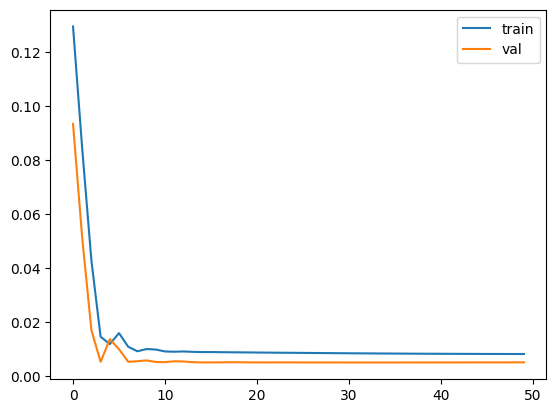

In [27]:
plt.plot(best_model_diesel.history_['loss'], label='train')
plt.plot(best_model_diesel.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [29]:
y_pred_diesel = best_model_diesel.predict(X_test_diesel)
y_pred_diesel = y_pred_diesel.reshape(-1, 1)
y_pred_diesel = scaler.inverse_transform(y_pred_diesel)
y_test_diesel_normal = scaler.inverse_transform(y_test_diesel.copy().reshape(-1, 1))

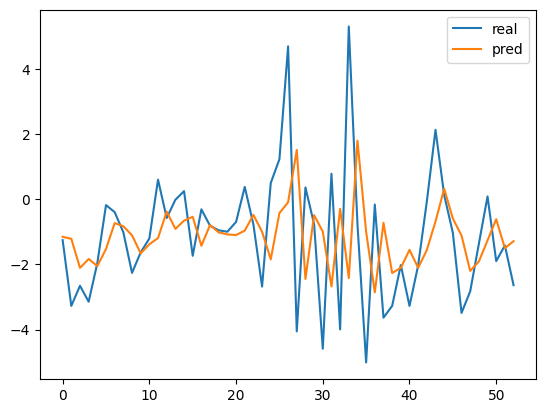

In [30]:
plt.plot(y_test_diesel_normal, label='real')
plt.plot(y_pred_diesel, label='pred')
plt.legend()
plt.show()

#### Regular

In [31]:
def create_model_regular(lstm_units=50, dense_units=25):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(dense_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [32]:
model_regular = KerasRegressor(model=create_model_regular, verbose=0)

In [33]:
param_grid_regular = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [50, 100]    
}

grid_regular = GridSearchCV(estimator=model_regular, param_grid=param_grid_regular, cv=3, verbose=1, n_jobs=-1)

In [34]:
grid_result_regular = grid_regular.fit(X_train_regular, y_train_regular, validation_data=(X_val_regular, y_val_regular))

print(f"Mejor resultado: {grid_result_regular.best_score_} usando {grid_result_regular.best_params_}")

best_model_regular = grid_result_regular.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor resultado: 0.17196106105310813 usando {'batch_size': 32, 'epochs': 50, 'model__dense_units': 25, 'model__lstm_units': 100}


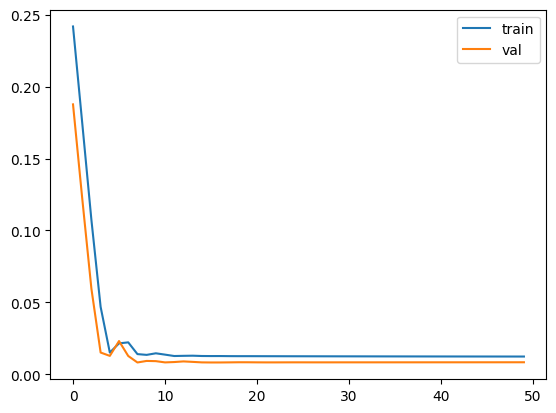

In [35]:
plt.plot(best_model_regular.history_['loss'], label='train')
plt.plot(best_model_regular.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [36]:
y_pred_regular = best_model_regular.predict(X_test_regular)
y_pred_regular = y_pred_regular.reshape(-1, 1)
y_pred_regular = scaler.inverse_transform(y_pred_regular)
y_test_regular_normal = scaler.inverse_transform(y_test_regular.copy().reshape(-1, 1))

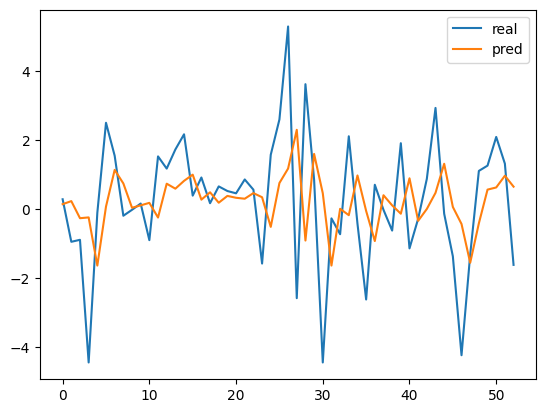

In [37]:
plt.plot(y_test_regular_normal, label='real')
plt.plot(y_pred_regular, label='pred')
plt.legend()
plt.show()

#### Super

In [38]:
def create_model_super(lstm_units=50, dense_units=25):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(dense_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [39]:
model_super = KerasRegressor(model=create_model_super, verbose=0)

In [40]:
param_grid_super = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [50, 100]    
}

grid_super = GridSearchCV(estimator=model_super, param_grid=param_grid_super, cv=3, verbose=1, n_jobs=-1)

In [41]:
grid_result_super = grid_super.fit(X_train_super, y_train_super, validation_data=(X_val_super, y_val_super))

print(f"Mejor resultado: {grid_result_super.best_score_} usando {grid_result_super.best_params_}")

best_model_super = grid_result_super.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\DataSci\GUA-Gasoline-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor resultado: 0.16443987944550933 usando {'batch_size': 32, 'epochs': 100, 'model__dense_units': 50, 'model__lstm_units': 100}


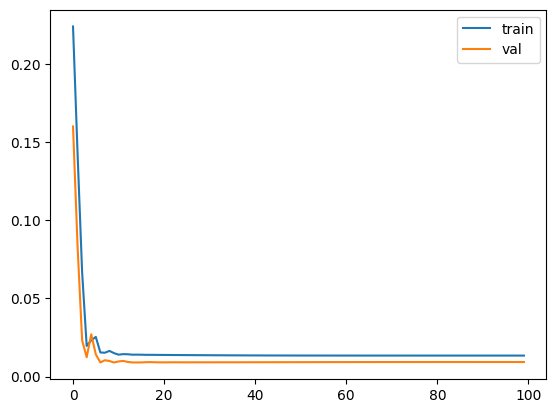

In [42]:
plt.plot(best_model_super.history_['loss'], label='train')
plt.plot(best_model_super.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [43]:
y_pred_super = best_model_super.predict(X_test_super)
y_pred_super = y_pred_super.reshape(-1, 1)
y_pred_super = scaler.inverse_transform(y_pred_super)
y_test_super_normal = scaler.inverse_transform(y_test_super.copy().reshape(-1, 1))

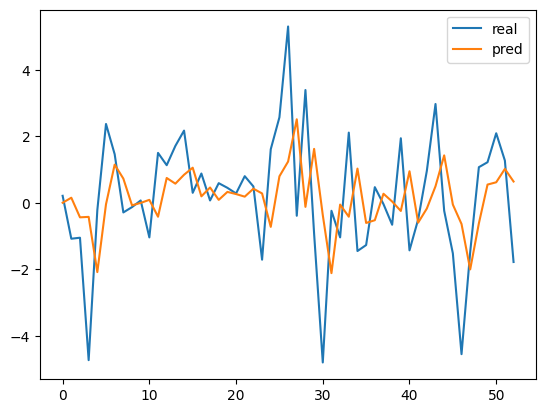

In [44]:
plt.plot(y_test_super_normal, label='real')
plt.plot(y_pred_super, label='pred')
plt.legend()
plt.show()

### Versión 2
Se ha realizado una LSTM de 50 neuronas que retorna secuencias, para luego hacer un dropout de 0.2. Procede a una capa LSTM bidireccional de 50 neuronas que no retorna secuencias. Se añade un dropout de 0.2 y una capa densa de 25 neuronas. Finalmente, se añade una capa de salida.

#### Diesel

In [45]:
def create_model_diesel_v2(lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [46]:
model_diesel_v2 = KerasRegressor(model=create_model_diesel_v2, verbose=0)

In [49]:
param_grid_diesel_v2 = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_diesel_v2 = GridSearchCV(estimator=model_diesel_v2, param_grid=param_grid_diesel_v2, cv=3, verbose=1, n_jobs=-1)

In [50]:
grid_result_diesel_v2 = grid_diesel_v2.fit(X_train_diesel, y_train_diesel, validation_data=(X_val_diesel, y_val_diesel))

print(f"Mejor resultado: {grid_result_diesel_v2.best_score_} usando {grid_result_diesel_v2.best_params_}")

best_model_diesel_v2 = grid_result_diesel_v2.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\DataSci\GUA-Gasoline-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor resultado: 0.1397661658362945 usando {'batch_size': 64, 'epochs': 50, 'model__dense_units': 50, 'model__dropout_rate': 0.2, 'model__lstm_units': 100}


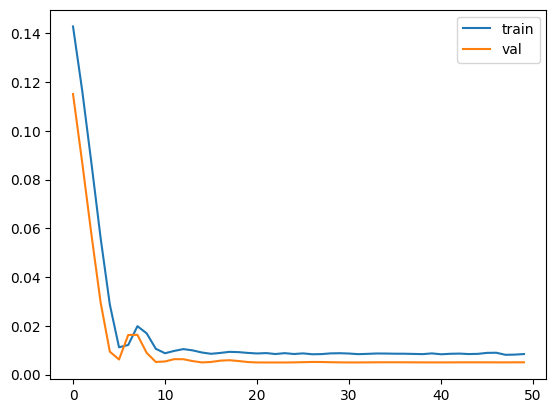

In [51]:
plt.plot(best_model_diesel_v2.history_['loss'], label='train')
plt.plot(best_model_diesel_v2.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [52]:
y_pred_diesel_v2 = best_model_diesel_v2.predict(X_test_diesel)
y_pred_diesel_v2 = y_pred_diesel_v2.reshape(-1, 1)
y_pred_diesel_v2 = scaler.inverse_transform(y_pred_diesel_v2)
y_test_diesel_v2_normal = scaler.inverse_transform(y_test_diesel.copy().reshape(-1, 1))

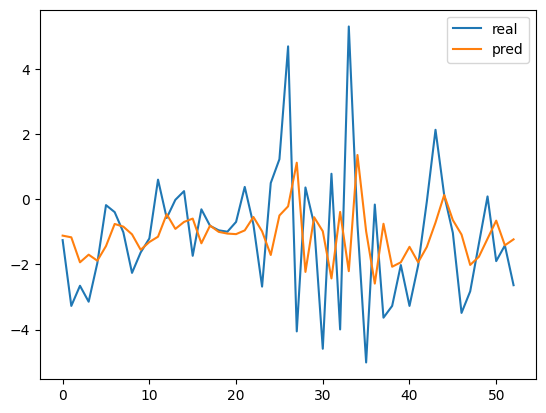

In [53]:
plt.plot(y_test_diesel_v2_normal, label='real')
plt.plot(y_pred_diesel_v2, label='pred')
plt.legend()
plt.show()

#### Regular

In [54]:
def create_model_regular_v2(lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [55]:
model_regular_v2 = KerasRegressor(model=create_model_regular_v2, verbose=0)

In [56]:
param_grid_regular_v2 = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_regular_v2 = GridSearchCV(estimator=model_regular_v2, param_grid=param_grid_regular_v2, cv=3, verbose=1, n_jobs=-1)

In [57]:
grid_result_regular_v2 = grid_regular_v2.fit(X_train_regular, y_train_regular, validation_data=(X_val_regular, y_val_regular))

print(f"Mejor resultado: {grid_result_regular_v2.best_score_} usando {grid_result_regular_v2.best_params_}")

best_model_regular_v2 = grid_result_regular_v2.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\DataSci\GUA-Gasoline-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor resultado: 0.17841457153746773 usando {'batch_size': 64, 'epochs': 50, 'model__dense_units': 25, 'model__dropout_rate': 0.2, 'model__lstm_units': 50}


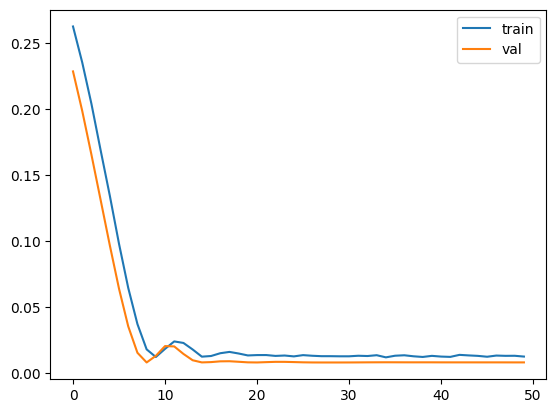

In [58]:
plt.plot(best_model_regular_v2.history_['loss'], label='train')
plt.plot(best_model_regular_v2.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [59]:
y_pred_regular_v2 = best_model_regular_v2.predict(X_test_regular)
y_pred_regular_v2 = y_pred_regular_v2.reshape(-1, 1)
y_pred_regular_v2 = scaler.inverse_transform(y_pred_regular_v2)
y_test_regular_v2_normal = scaler.inverse_transform(y_test_regular.copy().reshape(-1, 1))

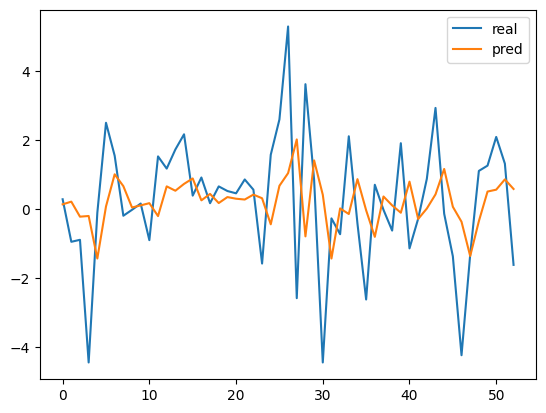

In [60]:
plt.plot(y_test_regular_v2_normal, label='real')
plt.plot(y_pred_regular_v2, label='pred')
plt.legend()
plt.show()

#### Super

In [61]:
def create_model_super_v2(lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [62]:
model_super_v2 = KerasRegressor(model=create_model_super_v2, verbose=0)

In [63]:
param_grid_super_v2 = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_super_v2 = GridSearchCV(estimator=model_super_v2, param_grid=param_grid_super_v2, cv=3, verbose=1, n_jobs=-1)

In [64]:
grid_result_super_v2 = grid_super_v2.fit(X_train_super, y_train_super, validation_data=(X_val_super, y_val_super))

print(f"Mejor resultado: {grid_result_super_v2.best_score_} usando {grid_result_super_v2.best_params_}")

best_model_super_v2 = grid_result_super_v2.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\DataSci\GUA-Gasoline-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor resultado: 0.17544424389725108 usando {'batch_size': 64, 'epochs': 50, 'model__dense_units': 50, 'model__dropout_rate': 0.3, 'model__lstm_units': 100}


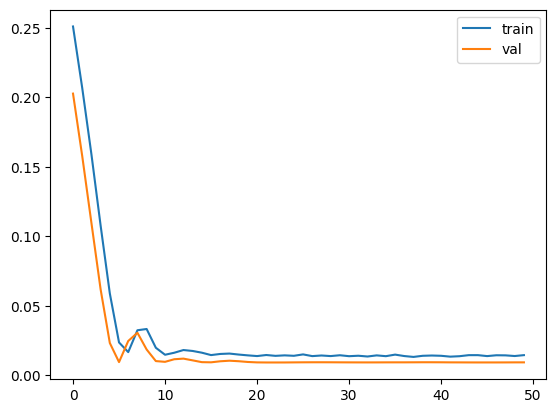

In [65]:
plt.plot(best_model_super_v2.history_['loss'], label='train')
plt.plot(best_model_super_v2.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [66]:
y_pred_super_v2 = best_model_super_v2.predict(X_test_super)
y_pred_super_v2 = y_pred_super_v2.reshape(-1, 1)
y_pred_super_v2 = scaler.inverse_transform(y_pred_super_v2)
y_test_super_v2_normal = scaler.inverse_transform(y_test_super.copy().reshape(-1, 1))

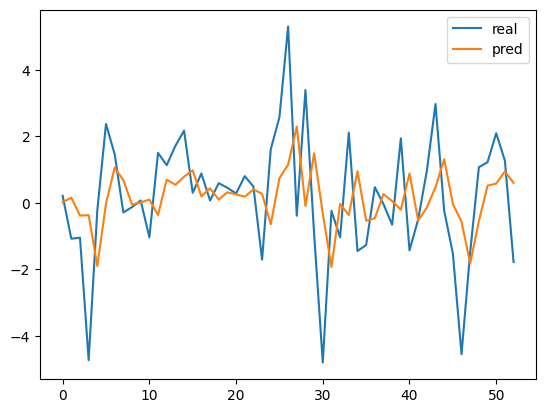

In [67]:
plt.plot(y_test_super_v2_normal, label='real')
plt.plot(y_pred_super_v2, label='pred')
plt.legend()
plt.show()